# Homework 5: Finite element method

Author: Will Eaton \
Last updated: Tuesday 15th March 



### Weak form equations 

We seek to solve the differential equation 
$$ \partial_x^2 T + f(x) = 0 $$ 

The weak form of this equation is therefore 
$$ \int_D w \partial_x^2 T dx + \int_D w f dx = 0 $$ where $D$ is the domain and $w$ is an arbitrary test function. 

Using a reverse chain rule we can rewrite the first term to get 

$$ \int_D  \partial_x (w \partial_x T) dx  - \int_D  \partial_x w \partial_x T dx  + \int_D w f(x) dx = 0. $$


Now comes the time to actually define our domain and the boundary conditions: 

$$ x \in [0,1]$$ 
$$ \partial_x T (x=0) = -q_0 $$
$$ T(x=1) = T_1 $$
$$ w(x=1) = 0 $$




By evaluating the first integral we then get: 

$$ w(1)\partial_x T(1) - w(0)\partial_x T(0)  - \int_0^1  \partial_x w \partial_x T dx  + \int_0^1 w f(x) dx = 0. $$

such that the first term disappears and we get: 

$$  w(0)q_0  - \int_0^1  \partial_x w \partial_x T dx  + \int_0^1 w f(x) dx = 0. $$


The next step is then to approximate/discretise $T$ and $w$ by expressing them as a finite summation of shape functions, 

$$ T = T_1 N_{n+1}(x) + \sum_{B=1}^n d_B N_B(x) $$ 
$$ w(x) = \sum_{A=1}^n c_A N_A(x),$$

where the first term of $T$ is to implement the RHS boundary condition. From this the weak form equation becomes 

$$  \sum_{A=1}^n c_A N_A(0)q_0  - \int_0^1  \partial_x \big( \sum_{A=1}^n c_A N_A(x)\big)\partial_x \big( T_1 N_{n+1}(x) + \sum_{B=1}^n d_B N_B(x)\big) dx  + \int_0^1 \sum_{A=1}^n c_A N_A(x) f(x) dx = 0. $$

$$  \sum_{A=1}^n  \Bigg[ c_A N_A(0)q_0  - c_A T_1 \int_0^1   \partial_x N_A(x) \partial_x N_{n+1}(x) dx  + c_A \int_0^1   N_A(x) f(x) dx \Bigg] =  \sum_{A=1}^n \sum_{B=1}^n   c_A d_B   \int_0^1  \partial_x \big(N_A(x)\big)\partial_x \big(N_B(x)\big) dx. $$


#### Choosing shape functions

Here I use linear shape functions that are defined by 

\begin{equation}
    N_e =
    \begin{cases}
       \frac{x \: - \: (e-1)h}{h} , & (e-1)h \leq x < eh \\
       \frac{(e+1)h \: - \: x}{h} , & eh \leq x < (e+1)h
    \end{cases}
  \end{equation}
 
 The functions for generating these shape functions are below. An example of $n = 4$ is shown here (note that I also plot $n+1$): 

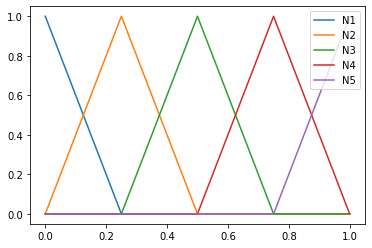

In [2]:
def gen_N(x, e, h):
    # Generate individual linear shape function for element e with element width h 
    N    = x*0
    grad = x*0
    N[(x>=(e-1)*h) & (x<=e*h)] = (x[(x>=(e-1)*h) & (x<=e*h)] - (e-1)*h )/h
    N[(x>=e*h) & (x<=(e+1)*h)] = ((e+1)*h -  x[(x>=e*h) & (x<=(e+1)*h)] )/h

    return N


def gen_shape_funcs(x, ne, h):
    # Generate array of linear shape functions for all elements ne with element width h 
    N = np.zeros((ne+1, len(x)))
    for n_el in range(ne):
        n = gen_N(x, n_el, h)
        N[n_el+1, :] = n

    return N


import numpy as np 
import matplotlib.pyplot as plt 

n = 4                   # Number of elements/shape functions
h = 1/n                 # Element spacing 
x = np.arange(n+1)/n    # x array 


fig_shapefuncs, ax_shapefuncs = plt.subplots()
leg_labels = []         # Collect labels for figure legend 

for ne in range(n+1):
    Ne = gen_N(x, e=ne, h=h)      # Generate shape function
    ax_shapefuncs.plot(x, Ne)     # Plot
    leg_labels.append(f"N{ne+1}") # Add to legend 
    
ax_shapefuncs.legend(leg_labels)

plt.show()

Returning to our weak form equation, and choosing $C_A = 1$,

$$  \sum_{A=1}^n  \Bigg[N_A(0)q_0  - T_1 \int_0^1   \partial_x N_A(x) \partial_x N_{n+1}(x) dx  + \int_0^1   N_A(x) f(x) dx \Bigg] =  \sum_{A=1}^n \sum_{B=1}^n   d_B   \int_0^1  \partial_x \big(N_A(x)\big)\partial_x \big(N_B(x)\big) dx. $$

it is therefore clear that $ N_A(0)q_0 $ is only non-zero when $A = 1$ and $\int_0^1   \partial_x N_A(x) \partial_x N_{n+1}(x) dx$ is only non-zero when $A = n$.

We can therefore write the above equation in a tensor format: 
$$ \mathbf{F} = \mathbf{K}\mathbf{d}$$
where 
$$\mathbf{F} = \begin{bmatrix}
\int_0^1   N_1(x) f(x) dx   + q_0 \\
\int_0^1   N_2(x) f(x) dx  \\
\int_0^1   N_3(x) f(x) dx  \\
\vdots                     \\
\int_0^1   N_n(x) f(x) dx - T_1 \int_0^1 \partial_x N_n \partial_x N_{n+1} dx   \\
\end{bmatrix}  $$

and 

$$ K_{ij} = \int_0^1  \partial_x N_i(x)\partial_x N_j(x) dx. $$

Due to the commutativity of the partial derivatives $K_{ij} = K_{ji}$. Further, due to the fact that only $N_{n-1}$ and $N_{n+1}$ are non-zero when $N_n$ is non-zero, $\mathbf{K}$ is a tridiagonal, symmetric matrix: 

$$
\mathbf{K} = \frac{1}{h} \begin{bmatrix}
1 & -1 & 0 & 0 & \dots & 0 \\
-1 & 2 & -1 & 0 & \dots & 0\\
0 & -1 & 2 & -1 & \dots & 0\\
0 & 0 & -1 & 2 & \dots & 0 \\
\vdots & \vdots & \vdots & \vdots & \ddots & -1 \\
0 & 0 & 0 & 0 & -1 & 2
\end{bmatrix}  
$$

Because of different shape of $N_1$ compared to any other shape functions, $K_{11}$ has a different value to the other diagonal elements. 


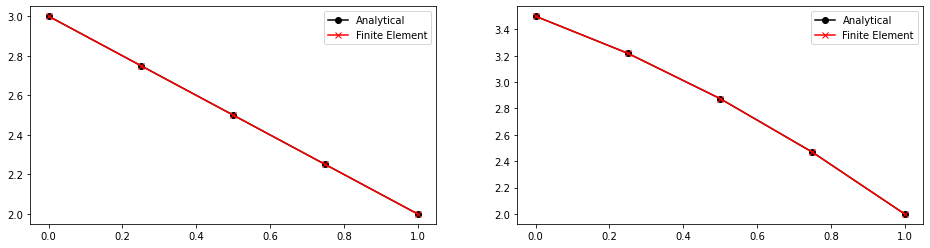

In [21]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import scipy.sparse as ss
import scipy.integrate as spi


# Define domain parameters:
n = 4                                               # Number of elements
h = 1/n                                              # Element width     
T1 = 2                                               # Boundary condition 1
q0 = 1                                               # Boundary condition 2
x = np.arange(n+1)/n                                 # x-array                             

# Create output figure
fig, ax = plt.subplots(1,2, figsize=(16,4))

# Create stiffness matrix:
K = ss.diags([-1, 2, -1], [-1, 0, 1], shape=(n,n))   # Create sparse matrix 
K.data[1,0] = 1                                      # Need to set 0,0 to 1 instead of 2
K = K.toarray()/(h)                                  # Convert to normal array 

for f in [0, 1]:
    # Create force vector:
    F = np.zeros(n)                                       

    for ne in range(n):
        Ne = gen_N(x, e=ne, h=h)

        # Integrate area under N*f and
        F[ne] = spi.trapz(y=Ne*f, dx=h)


        
    F[0]  +=  q0
    F[-1] +=  T1/h

    
    d = np.matmul(np.linalg.inv(K), F)

    u = np.zeros(n+1)
    for ne in range(n):
        u += gen_N(x, e=ne, h=h)*d[ne]
    u += T1*gen_N(x, e=n, h=h)


    # Plotting
    analytical = T1 + (1-x)*q0 + 0.5*(1 - x*x)*f    


    ax[f].plot(x, analytical, 'k-o')
    ax[f].plot(x, u,          'r-x')
    ax[f].legend(["Analytical", "Finite Element"])
    
plt.show()

The above mechanism creates the whole global matrix at once. The code below does a similar thing but evaluates the integrals in each element individually. I also wrote a version in C++ which I have edited more recently and definitely works where as the python version below is a little confused. 

To run the C++ version it requires compilation with C++11: 

```g++ -std=c++11 local.cpp -o local -Wall```

And then execution with 

```./local``` . 

I will also note that I am still learning C++ and so did not use pointers to 2D arrays becuase the syntax still confuses me. This means that the functions transfer the actual matrices instead of just pointers so it runs very slowly...I will try and make this better for the next homework! I also havent plotted the results but I have checked they are the same for a few examples. 

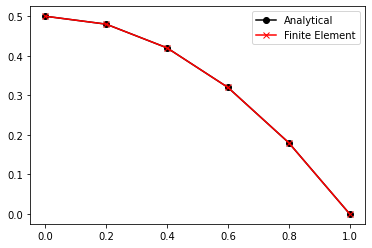

In [23]:
# We want to solve for Kd = f but in this local form we want to solve for local elements:
# Define domain parameters:
n = 5  # Number of elements
h = 1 / n  # Element width
T1 = 0  # Boundary condition 1
q0 = 0  # Boundary condition 2
x = np.arange(n + 1) / n  # x-array
f = 1

# Get all shape functions including n+1 (note first row of array is empty)
Ns = gen_shape_funcs(x, n+1, h)

# Initialise global matrices:
K = np.zeros((n+1,n+1))
F = np.zeros(n)


for el in range(n):
    # Get part of shape function within element:
    NA  = Ns[el+1, el:el+2]
    NA1 = Ns[el+2, el:el+2]

    # Get gradient:
    NA_g  = (NA[1]  - NA[0]) /h  + NA*0 # To get correct shape
    NA1_g = (NA1[1] - NA1[0])/h  + NA*0 # To get correct shape

    # Add local matrix values of k (RHS) to global K matrix
    K[el,el] += spi.trapz(y=NA_g * NA_g, dx=h)
    K[el,el+1] += spi.trapz(y=NA_g * NA1_g, dx=h)
    K[el+1, el] += spi.trapz(y=NA_g * NA1_g, dx=h)
    K[el+1,el+1] += spi.trapz(y=NA1_g * NA1_g, dx=h)

    # Do in two seperate integrals so that the ne=0 term doesnt affect calculation:
    F[el] += spi.trapz(y=Ns[el+1, el:el+2] * f, dx=h)
    F[el] += spi.trapz(y=Ns[el + 1, el-1:el+1] * f, dx=h)

# Apply boundary components
F[0] += q0
F[-1] += T1/h

fig, ax = plt.subplots()

d = np.matmul(np.linalg.inv(K[:-1, :-1]), F)

u = np.zeros(n + 1)
for ne in range(n):
    u += gen_N(x, e=ne, h=h) * d[ne]
u += T1 * gen_N(x, e=n, h=h)

# Plotting
analytical = T1 + (1 - x) * q0 + 0.5 * (1 - x * x) * f

ax.plot(x, analytical, 'k-o')
ax.plot(x, u, 'r-x')
ax.legend(["Analytical", "Finite Element"])

plt.show()